In [1]:
!pip install rasterio

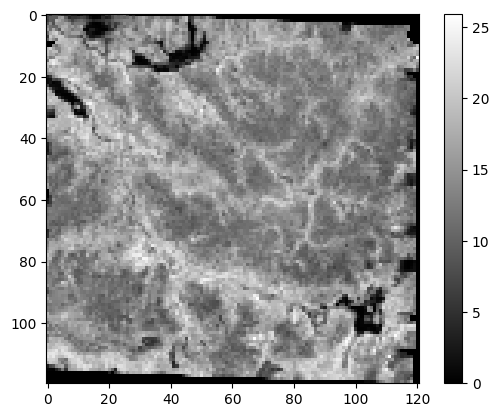

In [ ]:
# FINDING DN VALUES AFTER READING
import rasterio
import numpy as np
import matplotlib.pyplot as plt

canopy_hgt = "/content/drive/MyDrive/NRSC/chm_raster100.tif"
s2_file = "/content/drive/MyDrive/NRSC/Sentinel_2022.tif"

with rasterio.open(canopy_hgt) as src:
    dn_values = src.read(1)

dn_values = np.array(dn_values)
mask = (dn_values < 0) & ~np.isnan(dn_values)

dn_values[mask] = 0

plt.imshow(dn_values, cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
# STORING THOSE DN VALUES IN A CSV FILE
from google.colab import drive
import csv

folder_id = 'NRSC'
csv_file_path = "/content/drive/MyDrive/NRSC/hgt_pixels.csv"

with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Patch ID', 'DN_Values'])

with open(csv_file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    for i in range(dn_values.shape[0]):
        for j in range(dn_values.shape[1]):
            patch_name = f"Patch_{i}_{j}"
            dn_value = dn_values[i, j]
            writer.writerow([patch_name, dn_value])


In [ ]:
# CREATING SHAPEFILES FROM THE RASTER IMAGE
import geopandas as gpd
from shapely.geometry import box
import rasterio

canopy_height_path = "/content/drive/MyDrive/NRSC/chm_raster100.tif"
output_folder = "/content/drive/MyDrive/NRSC/Shapefiles/"

src = rasterio.open(canopy_height_path)
pixel_size = src.transform[0]

start_x = src.transform[2]
start_y = src.transform[5]

counter = 0
for row in range(src.shape[0]):
    for col in range(src.shape[1]):
        counter += 1
        end_x = start_x + pixel_size
        end_y = start_y - pixel_size

        bounding_box = box(start_x, start_y, end_x, end_y)
        gdf = gpd.GeoDataFrame(geometry=[bounding_box], crs=src.crs)

        shapefile_output_path = f"{output_folder}shapefile_{row}_{col}.shp"

        gdf.to_file(shapefile_output_path)
        print(f"Shapefile saved at: {shapefile_output_path}")
        start_x = end_x

    if (row+1)%10==0:
        print(f'Number of shapefiles: {counter}')

    start_x = src.transform[2]
    start_y -= pixel_size


In [ ]:
# CLIPPING PATCHES FROM THE SENTINEL-2 IMAGE USING RASTER IMAGE SHAPEFILES AS REFERENCE
from rasterio.mask import mask
import geopandas as gpd
import rasterio

sentinel_image_path = "/content/drive/MyDrive/NRSC/Sentinel_2022.tif"

rows = 120
cols = 121
for i in range(rows):
  for j in range(cols):
    shapefile_path = f"/content/drive/MyDrive/NRSC/Shapefiles/shapefile_{i}_{j}.shp"
    clipped_output_path = f"/content/drive/MyDrive/NRSC/Clipped_images/patch_{i}_{j}.tif"

    shapefile = gpd.read_file(shapefile_path)
    sentinel_crs = rasterio.open(sentinel_image_path).crs
    shapefile = shapefile.to_crs(sentinel_crs)

    shapefile_bounds = shapefile.total_bounds

    with rasterio.open(sentinel_image_path) as src:
        window = rasterio.windows.from_bounds(*shapefile_bounds, transform=src.transform)

        if 0 < window.width <= src.width and 0 < window.height <= src.height:
            clipped_data, clipped_transform = src.read(window=window), src.window_transform(window)
            clipped_meta = src.meta.copy()
            clipped_meta.update({"transform": clipped_transform,
                                "height": clipped_data.shape[1],
                                "width": clipped_data.shape[2],
                                "crs": src.crs})

            with rasterio.open(clipped_output_path, "w", **clipped_meta) as dest:
                dest.write(clipped_data)

            print("Clipping completed successfully. Clipped image saved at:", clipped_output_path)
        else:
            print("Error: Window is empty or invalid. Please check the bounding box coordinates.")


In [ ]:
# EXCLUDING THE NOT NEEDED PATCHES WHOSE DN VALUES WOULD LESS THAN ZERO USING CSV FILE
import os
import shutil

clipped_images_folder = "/content/drive/MyDrive/NRSC/Clipped_images"
new_folder = "/content/drive/MyDrive/NRSC/New_Clipped_images"

for image_filename in os.listdir(clipped_images_folder):
    if image_filename.endswith(".tif"):
        patch_id_from_filename = os.path.splitext(image_filename)[0]

        if patch_id_from_filename in hgt_df_new['Patch ID'].values:
            image_file_path = os.path.join(clipped_images_folder, image_filename)

            try:
                shutil.copy(image_file_path, new_folder)
                print(f"Image {image_filename} copied successfully.")
            except Exception as e:
                print(f"Error occurred while copying image {image_filename}: {e}")
        else:
            print(f"Patch ID '{patch_id_from_filename}' not found in the DataFrame.")


# Extracting Mean, SD, Min and Max values

In [9]:
# MEAN
import rasterio
import os

# Path to the Sentinel-2 image dataset
sentinel_image_path = "/kaggle/input/project1/Sentinel_2022 (3).tif"

#output_folder = "/content/drive/MyDrive/NRSC/Parameter_values"

band_mean = []
band_std = []
band_min = []
band_max = []

# Open the Sentinel-2 image
with rasterio.open(sentinel_image_path) as src:
    # Loop through each band
    for band_number in range(1, src.count + 1):
        # Read the band data
        band_data = src.read(band_number)

        # Compute the mean
        band_mean.append(band_data.mean())
        band_std.append(band_data.std())
        band_min.append(band_data.min())
        band_max.append(band_data.max())

        # Store the mean value in a text file
        #parameter_name = f"mean_band{band_number}.txt"
        #output_file_path = os.path.join(output_folder, parameter_name)
        #with open(output_file_path, 'w') as f:
            #f.write(str(mean_value))


In [10]:
band_mean, band_std ,band_min, band_max

([205.50667857940584,
  338.1868560521453,
  202.5277695426456,
  603.5985149687629,
  2023.1472989894478,
  2556.898537982009,
  2709.065901137802,
  1336.9043948531553,
  592.1683858915264],
 [47.755313506682675,
  67.92542194155001,
  79.47636136545246,
  115.35385947673218,
  238.81464500715396,
  305.89980603340865,
  387.83081943462383,
  197.25797369243642,
  140.18532943799747],
 [0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1150, 1476, 1636, 1951, 3668, 4656, 5368, 3400, 2595])

In [11]:
band_mean = [205.50667857940584, 338.1868560521453, 202.5277695426456, 603.5985149687629, 2023.1472989894478, 2556.898537982009, 2709.065901137802,
  1336.9043948531553, 592.1683858915264],
band_std = [47.755313506682675, 67.92542194155001, 79.47636136545246, 115.35385947673218, 238.81464500715396, 305.89980603340865, 387.83081943462383,
  197.25797369243642, 140.18532943799747]


In [8]:
# Provided band statistics for initial calculation
band_mean = [205.50667857940584, 338.1868560521453, 202.5277695426456, 603.5985149687629, 2023.1472989894478, 2556.898537982009, 2709.065901137802, 1336.9043948531553, 592.1683858915264]
band_std = [47.755313506682675, 67.92542194155001, 79.47636136545246, 115.35385947673218, 238.81464500715396, 305.89980603340865, 387.83081943462383, 197.25797369243642, 140.18532943799747]
band_min = [0, 0, 0, 0, 0, 0, 0, 0, 0]
band_max = [1150, 1476, 1636, 1951, 3668, 4656, 5368, 3400, 2595]

# Correct normalization calculation
normalized_band_mean = [(mean - min_val) / (max_val - min_val) for mean, min_val, max_val in zip(band_mean, band_min, band_max)]
normalized_band_std = [(std - min_val) / (max_val - min_val) for std, min_val, max_val in zip(band_std, band_min, band_max)]

# Print results to verify correctness
print("Normalized mean values for each band:", normalized_band_mean)
print("Normalized std values for each band:", normalized_band_std)


Normalized mean values for each band: [0.17870145963426595, 0.22912388621419058, 0.12379448016054131, 0.30937904406394817, 0.5515668754060654, 0.5491620571267202, 0.5046695046828991, 0.3932071749568104, 0.2281959097847886]
Normalized std values for each band: [0.04152635957102841, 0.04601993356473578, 0.048579682986217884, 0.059125504601092865, 0.06510759133237567, 0.06570013016181457, 0.07224866233878983, 0.05801705108601071, 0.05402132155606839]


# Dataset Preparation

In [6]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import numpy as np
import os
import rasterio
import pandas as pd

class GeoTIFFDataset(Dataset):
    def __init__(self, root_dir, hgt_csv, band_mean, band_std, transform=None):
        self.root_dir = root_dir
        self.band_mean = band_mean
        self.band_std = band_std
        self.csv_data = hgt_csv
        self.transform = transform
        self.file_list = os.listdir(root_dir)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError("Index %d is out of range" % idx)
        
        image_name = self.file_list[idx]
        image_id = self.file_list[idx].split('.')[0][:1].upper() + self.file_list[idx].split('.')[0][1:]
        filtered_df = self.csv_data[self.csv_data['Patch ID'] == image_id].reset_index()
        value = filtered_df.loc[0, 'DN_Values'].astype(np.float32)

        img_path = os.path.join(self.root_dir, image_name[:1].lower() + image_name[1:])
        img = rasterio.open(img_path)
        image_np = img.read().astype(np.float32)  

        if image_np.shape[0] != len(self.band_mean):
            raise ValueError(f"Image {image_name} has {image_np.shape[0]} channels but expected {len(self.band_mean)}.")

        for i in range(image_np.shape[0]):
            image_np[i, :, :] = (image_np[i, :, :] - self.band_mean[i]) / self.band_std[i]

        image_np = np.transpose(image_np, (1, 2, 0)) 

        if self.transform:
            image = self.transform(image_np)
        else:
            to_tensor = transforms.ToTensor()
            image = to_tensor(image_np)

        return image, value

band_mean = [0.485, 0.456, 0.406, 0.485, 0.456, 0.406, 0.485, 0.456, 0.406]
band_std = [0.229, 0.224, 0.225, 0.229, 0.224, 0.225, 0.229, 0.224, 0.225]

root_dir = '/kaggle/input/project1/New_Clipped_images-20240520T155116Z-001/New_Clipped_images'

hgt_csv = pd.read_csv('/kaggle/input/project1/hgt_pixels.csv')
hgt_csv_valid = hgt_csv[hgt_csv.DN_Values > 0]

dataset = GeoTIFFDataset(root_dir, hgt_csv_valid, band_mean, band_std)

val_split = 0.2
seed = 42
torch.manual_seed(seed)
batch_size = 4096

train_set, val_set = random_split(dataset, [int(len(dataset) * (1 - val_split)), len(dataset) - int(len(dataset) * (1 - val_split))])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)



In [ ]:
for images,values in train_loader:
    first_image = images[0]
    first_value = values[0]
    break

In [ ]:
# Accessing individual sample (image, value)
image, value = dataset[0]
print(image.shape)
print(value)

# Model Setting 

In [7]:
import torch
from torch import nn

class HeightCNN(nn.Module):
  def __init__(self):
    super(HeightCNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=9, out_channels=16, kernel_size=3, padding=1)
    self.relu1 = nn.ReLU(inplace=True)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.relu2 = nn.ReLU(inplace=True)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(in_features=32 * 2 * 2, out_features=64)
    self.relu3 = nn.ReLU(inplace=True)
    self.fc2 = nn.Linear(in_features=64, out_features=1)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.relu2(x)
    x = self.pool2(x)
    x = torch.flatten(x, 1)  
    x = self.fc1(x)
    x = self.relu3(x)
    x = self.fc2(x)
    return x


In [8]:
def save_checkpoint(epoch, model, optimizer, filename="height_model_{epoch}.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, filename.format(epoch=epoch))

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Model Training

In [10]:
import tqdm

num_epochs = 100
model = HeightCNN()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f"Epoch: {epoch+1}/{num_epochs}")

    train_loss = 0
    model.train()  
    pbar = tqdm.tqdm(total=len(train_loader))
    for images, values in train_loader:
        images = images.to(device)
        values = values.to(device)
        
        optimizer.zero_grad()

        output = model(images)
        values = values.view(images.shape[0], 1)
        loss = criterion(output, values)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pbar.update(1)
        if (epoch + 1) % 5 == 0:
            save_checkpoint(epoch + 1, model, optimizer) 
    pbar.close()
    
    val_loss = 0
    model.eval()  
    with torch.no_grad():  
        for images, values in val_loader:
            images = images.to(device)
            values = values.to(device)
            
            output = model(images)
            values = values.view(images.shape[0], 1)
            val_loss += criterion(output, values).item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    print(f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
model.eval()  
if device == "cuda":
    model = model.cpu()  

save_checkpoint(num_epochs, model.cpu(), optimizer)



Epoch: 1/100


100%|██████████| 3/3 [02:54<00:00, 58.30s/it]


Train Loss: 22846.3408, Validation Loss: 271.6954
Epoch: 2/100


100%|██████████| 3/3 [01:24<00:00, 28.23s/it]


Train Loss: 4763.4510, Validation Loss: 3896.5627
Epoch: 3/100


100%|██████████| 3/3 [01:25<00:00, 28.40s/it]


Train Loss: 1628.3519, Validation Loss: 992.8412
Epoch: 4/100


100%|██████████| 3/3 [01:25<00:00, 28.36s/it]


Train Loss: 1559.4266, Validation Loss: 1085.9397
Epoch: 5/100


100%|██████████| 3/3 [01:25<00:00, 28.54s/it]


Train Loss: 551.2837, Validation Loss: 454.1571
Epoch: 6/100


100%|██████████| 3/3 [01:28<00:00, 29.40s/it]


Train Loss: 716.3851, Validation Loss: 652.7516
Epoch: 7/100


100%|██████████| 3/3 [01:28<00:00, 29.38s/it]


Train Loss: 341.4022, Validation Loss: 297.4213
Epoch: 8/100


100%|██████████| 3/3 [01:27<00:00, 29.17s/it]


Train Loss: 420.5389, Validation Loss: 268.3370
Epoch: 9/100


100%|██████████| 3/3 [01:26<00:00, 28.91s/it]


Train Loss: 170.4474, Validation Loss: 189.1520
Epoch: 10/100


100%|██████████| 3/3 [01:26<00:00, 28.91s/it]


Train Loss: 238.6491, Validation Loss: 202.3258
Epoch: 11/100


100%|██████████| 3/3 [01:25<00:00, 28.66s/it]


Train Loss: 142.0724, Validation Loss: 141.5526
Epoch: 12/100


100%|██████████| 3/3 [01:24<00:00, 28.32s/it]


Train Loss: 125.3989, Validation Loss: 90.9335
Epoch: 13/100


100%|██████████| 3/3 [01:26<00:00, 28.86s/it]


Train Loss: 88.2074, Validation Loss: 83.6270
Epoch: 14/100


100%|██████████| 3/3 [01:25<00:00, 28.55s/it]


Train Loss: 86.7590, Validation Loss: 88.8654
Epoch: 15/100


100%|██████████| 3/3 [01:27<00:00, 29.25s/it]


Train Loss: 85.2503, Validation Loss: 78.8553
Epoch: 16/100


100%|██████████| 3/3 [01:27<00:00, 29.04s/it]


Train Loss: 80.1214, Validation Loss: 79.1630
Epoch: 17/100


100%|██████████| 3/3 [01:24<00:00, 28.30s/it]


Train Loss: 78.9962, Validation Loss: 73.2895
Epoch: 18/100


100%|██████████| 3/3 [01:24<00:00, 28.15s/it]


Train Loss: 73.6399, Validation Loss: 72.2405
Epoch: 19/100


100%|██████████| 3/3 [01:26<00:00, 28.83s/it]


Train Loss: 72.4775, Validation Loss: 68.3106
Epoch: 20/100


100%|██████████| 3/3 [01:25<00:00, 28.54s/it]


Train Loss: 70.2785, Validation Loss: 67.9827
Epoch: 21/100


100%|██████████| 3/3 [01:24<00:00, 28.31s/it]


Train Loss: 69.6638, Validation Loss: 66.0910
Epoch: 22/100


100%|██████████| 3/3 [01:26<00:00, 28.81s/it]


Train Loss: 67.4870, Validation Loss: 65.7356
Epoch: 23/100


100%|██████████| 3/3 [01:23<00:00, 27.76s/it]


Train Loss: 65.5692, Validation Loss: 64.3564
Epoch: 24/100


100%|██████████| 3/3 [01:25<00:00, 28.41s/it]


Train Loss: 65.1901, Validation Loss: 63.5980
Epoch: 25/100


100%|██████████| 3/3 [01:23<00:00, 27.69s/it]


Train Loss: 63.6087, Validation Loss: 63.0870
Epoch: 26/100


100%|██████████| 3/3 [01:22<00:00, 27.49s/it]


Train Loss: 62.3665, Validation Loss: 61.5492
Epoch: 27/100


100%|██████████| 3/3 [01:22<00:00, 27.57s/it]


Train Loss: 61.4521, Validation Loss: 60.3522
Epoch: 28/100


100%|██████████| 3/3 [01:26<00:00, 28.91s/it]


Train Loss: 59.9509, Validation Loss: 59.0725
Epoch: 29/100


100%|██████████| 3/3 [01:27<00:00, 29.13s/it]


Train Loss: 58.5589, Validation Loss: 58.2289
Epoch: 30/100


100%|██████████| 3/3 [01:26<00:00, 28.98s/it]


Train Loss: 57.3090, Validation Loss: 57.5896
Epoch: 31/100


100%|██████████| 3/3 [01:26<00:00, 28.93s/it]


Train Loss: 56.0322, Validation Loss: 56.5647
Epoch: 32/100


100%|██████████| 3/3 [01:30<00:00, 30.19s/it]


Train Loss: 54.8502, Validation Loss: 55.2881
Epoch: 33/100


100%|██████████| 3/3 [01:26<00:00, 28.68s/it]


Train Loss: 53.5032, Validation Loss: 53.8028
Epoch: 34/100


100%|██████████| 3/3 [01:28<00:00, 29.37s/it]


Train Loss: 52.2727, Validation Loss: 52.7174
Epoch: 35/100


100%|██████████| 3/3 [01:24<00:00, 28.10s/it]


Train Loss: 51.0592, Validation Loss: 51.5400
Epoch: 36/100


100%|██████████| 3/3 [01:26<00:00, 28.75s/it]


Train Loss: 49.8443, Validation Loss: 50.6276
Epoch: 37/100


100%|██████████| 3/3 [01:27<00:00, 29.23s/it]


Train Loss: 48.5908, Validation Loss: 49.1502
Epoch: 38/100


100%|██████████| 3/3 [01:25<00:00, 28.52s/it]


Train Loss: 47.2056, Validation Loss: 47.8939
Epoch: 39/100


100%|██████████| 3/3 [01:25<00:00, 28.64s/it]


Train Loss: 46.5216, Validation Loss: 46.8391
Epoch: 40/100


100%|██████████| 3/3 [01:24<00:00, 28.16s/it]


Train Loss: 45.4881, Validation Loss: 47.1230
Epoch: 41/100


100%|██████████| 3/3 [01:23<00:00, 27.74s/it]


Train Loss: 44.6705, Validation Loss: 45.7030
Epoch: 42/100


100%|██████████| 3/3 [01:24<00:00, 28.17s/it]


Train Loss: 44.1676, Validation Loss: 44.8134
Epoch: 43/100


100%|██████████| 3/3 [01:23<00:00, 27.89s/it]


Train Loss: 43.4355, Validation Loss: 45.0748
Epoch: 44/100


100%|██████████| 3/3 [01:24<00:00, 28.12s/it]


Train Loss: 42.9052, Validation Loss: 44.3258
Epoch: 45/100


100%|██████████| 3/3 [01:23<00:00, 27.91s/it]


Train Loss: 42.1652, Validation Loss: 43.2410
Epoch: 46/100


100%|██████████| 3/3 [01:24<00:00, 28.10s/it]


Train Loss: 41.6978, Validation Loss: 42.4060
Epoch: 47/100


100%|██████████| 3/3 [01:26<00:00, 28.75s/it]


Train Loss: 41.0098, Validation Loss: 42.3360
Epoch: 48/100


100%|██████████| 3/3 [01:24<00:00, 28.31s/it]


Train Loss: 40.4726, Validation Loss: 42.3194
Epoch: 49/100


100%|██████████| 3/3 [01:25<00:00, 28.49s/it]


Train Loss: 39.9771, Validation Loss: 41.7846
Epoch: 50/100


100%|██████████| 3/3 [01:25<00:00, 28.38s/it]


Train Loss: 40.0987, Validation Loss: 40.3928
Epoch: 51/100


100%|██████████| 3/3 [01:26<00:00, 28.86s/it]


Train Loss: 38.7883, Validation Loss: 39.9451
Epoch: 52/100


100%|██████████| 3/3 [01:26<00:00, 28.71s/it]


Train Loss: 38.3842, Validation Loss: 39.4631
Epoch: 53/100


100%|██████████| 3/3 [01:24<00:00, 28.14s/it]


Train Loss: 37.9120, Validation Loss: 38.9499
Epoch: 54/100


100%|██████████| 3/3 [01:23<00:00, 27.92s/it]


Train Loss: 37.5077, Validation Loss: 38.5229
Epoch: 55/100


100%|██████████| 3/3 [01:23<00:00, 27.78s/it]


Train Loss: 37.0641, Validation Loss: 38.0525
Epoch: 56/100


100%|██████████| 3/3 [01:23<00:00, 27.79s/it]


Train Loss: 36.5247, Validation Loss: 37.6775
Epoch: 57/100


100%|██████████| 3/3 [01:23<00:00, 27.94s/it]


Train Loss: 36.4043, Validation Loss: 37.2262
Epoch: 58/100


100%|██████████| 3/3 [01:21<00:00, 27.26s/it]


Train Loss: 35.8470, Validation Loss: 36.7715
Epoch: 59/100


100%|██████████| 3/3 [01:22<00:00, 27.57s/it]


Train Loss: 35.3212, Validation Loss: 37.1320
Epoch: 60/100


100%|██████████| 3/3 [01:23<00:00, 27.79s/it]


Train Loss: 35.5906, Validation Loss: 38.0529
Epoch: 61/100


100%|██████████| 3/3 [01:21<00:00, 27.30s/it]


Train Loss: 35.3807, Validation Loss: 34.6342
Epoch: 62/100


100%|██████████| 3/3 [01:21<00:00, 27.30s/it]


Train Loss: 33.4308, Validation Loss: 34.4498
Epoch: 63/100


100%|██████████| 3/3 [01:22<00:00, 27.57s/it]


Train Loss: 32.9618, Validation Loss: 33.5284
Epoch: 64/100


100%|██████████| 3/3 [01:21<00:00, 27.32s/it]


Train Loss: 32.3484, Validation Loss: 33.0823
Epoch: 65/100


100%|██████████| 3/3 [01:21<00:00, 27.32s/it]


Train Loss: 31.8653, Validation Loss: 32.6683
Epoch: 66/100


100%|██████████| 3/3 [01:22<00:00, 27.39s/it]


Train Loss: 31.3392, Validation Loss: 32.0511
Epoch: 67/100


100%|██████████| 3/3 [01:23<00:00, 27.91s/it]


Train Loss: 30.8976, Validation Loss: 31.4803
Epoch: 68/100


100%|██████████| 3/3 [01:24<00:00, 28.17s/it]


Train Loss: 30.3361, Validation Loss: 31.0655
Epoch: 69/100


100%|██████████| 3/3 [01:26<00:00, 28.91s/it]


Train Loss: 30.0096, Validation Loss: 30.6022
Epoch: 70/100


100%|██████████| 3/3 [01:29<00:00, 29.96s/it]


Train Loss: 29.6521, Validation Loss: 30.3321
Epoch: 71/100


100%|██████████| 3/3 [01:27<00:00, 29.02s/it]


Train Loss: 29.2689, Validation Loss: 29.6193
Epoch: 72/100


100%|██████████| 3/3 [01:28<00:00, 29.42s/it]


Train Loss: 28.4497, Validation Loss: 29.4559
Epoch: 73/100


100%|██████████| 3/3 [01:26<00:00, 28.71s/it]


Train Loss: 28.3526, Validation Loss: 29.0574
Epoch: 74/100


100%|██████████| 3/3 [01:26<00:00, 28.81s/it]


Train Loss: 27.7603, Validation Loss: 28.2777
Epoch: 75/100


100%|██████████| 3/3 [01:26<00:00, 28.91s/it]


Train Loss: 27.5794, Validation Loss: 28.2363
Epoch: 76/100


100%|██████████| 3/3 [01:26<00:00, 28.91s/it]


Train Loss: 27.1084, Validation Loss: 27.5338
Epoch: 77/100


100%|██████████| 3/3 [01:26<00:00, 28.68s/it]


Train Loss: 26.4767, Validation Loss: 27.1410
Epoch: 78/100


100%|██████████| 3/3 [01:25<00:00, 28.36s/it]


Train Loss: 26.2210, Validation Loss: 26.6861
Epoch: 79/100


100%|██████████| 3/3 [01:24<00:00, 28.31s/it]


Train Loss: 25.9640, Validation Loss: 26.3313
Epoch: 80/100


100%|██████████| 3/3 [01:26<00:00, 28.93s/it]


Train Loss: 25.5672, Validation Loss: 25.9568
Epoch: 81/100


100%|██████████| 3/3 [01:25<00:00, 28.55s/it]


Train Loss: 25.5576, Validation Loss: 25.7407
Epoch: 82/100


100%|██████████| 3/3 [01:25<00:00, 28.52s/it]


Train Loss: 25.2641, Validation Loss: 25.7112
Epoch: 83/100


100%|██████████| 3/3 [01:25<00:00, 28.57s/it]


Train Loss: 24.9054, Validation Loss: 26.6358
Epoch: 84/100


100%|██████████| 3/3 [01:25<00:00, 28.50s/it]


Train Loss: 25.1904, Validation Loss: 26.5171
Epoch: 85/100


100%|██████████| 3/3 [01:28<00:00, 29.54s/it]


Train Loss: 24.6752, Validation Loss: 25.6370
Epoch: 86/100


100%|██████████| 3/3 [01:34<00:00, 31.55s/it]


Train Loss: 24.2487, Validation Loss: 24.5488
Epoch: 87/100


100%|██████████| 3/3 [01:31<00:00, 30.43s/it]


Train Loss: 23.5260, Validation Loss: 23.9739
Epoch: 88/100


100%|██████████| 3/3 [01:24<00:00, 28.22s/it]


Train Loss: 23.2886, Validation Loss: 23.7413
Epoch: 89/100


100%|██████████| 3/3 [01:24<00:00, 28.17s/it]


Train Loss: 22.9069, Validation Loss: 23.5724
Epoch: 90/100


100%|██████████| 3/3 [01:25<00:00, 28.60s/it]


Train Loss: 22.8550, Validation Loss: 23.7094
Epoch: 91/100


100%|██████████| 3/3 [01:25<00:00, 28.65s/it]


Train Loss: 22.8144, Validation Loss: 23.6822
Epoch: 92/100


100%|██████████| 3/3 [01:26<00:00, 28.75s/it]


Train Loss: 22.6643, Validation Loss: 23.1084
Epoch: 93/100


100%|██████████| 3/3 [01:25<00:00, 28.65s/it]


Train Loss: 22.2856, Validation Loss: 22.7851
Epoch: 94/100


100%|██████████| 3/3 [01:24<00:00, 28.32s/it]


Train Loss: 22.0794, Validation Loss: 22.6969
Epoch: 95/100


100%|██████████| 3/3 [01:26<00:00, 28.82s/it]


Train Loss: 21.7735, Validation Loss: 22.2811
Epoch: 96/100


100%|██████████| 3/3 [01:26<00:00, 28.85s/it]


Train Loss: 21.7441, Validation Loss: 22.0815
Epoch: 97/100


100%|██████████| 3/3 [01:23<00:00, 27.86s/it]


Train Loss: 22.2652, Validation Loss: 22.4283
Epoch: 98/100


100%|██████████| 3/3 [01:23<00:00, 27.73s/it]


Train Loss: 22.1861, Validation Loss: 23.8189
Epoch: 99/100


100%|██████████| 3/3 [01:23<00:00, 27.90s/it]


Train Loss: 22.3519, Validation Loss: 23.6746
Epoch: 100/100


100%|██████████| 3/3 [01:24<00:00, 28.09s/it]


Train Loss: 22.0727, Validation Loss: 23.0214


# Predict for new image chip

In [11]:
band_mean = [205.50667857940584, 338.1868560521453, 202.5277695426456, 603.5985149687629, 2023.1472989894478, 2556.898537982009, 2709.065901137802,
  1336.9043948531553, 592.1683858915264],
band_std = [47.755313506682675, 67.92542194155001, 79.47636136545246, 115.35385947673218, 238.81464500715396, 305.89980603340865, 387.83081943462383,
  197.25797369243642, 140.18532943799747]

# Predict for a new image chip
def read_image(image_path):
    image_open = rasterio.open(image_path)
    image_np = image_open.read()
    image_np = np.transpose(image_np, (1, 2, 0))

    # Normalize each band
    normalized_img = np.zeros_like(image_np, dtype=np.float32)

    for i in range(image_np.shape[2]):
        normalized_img[:, :, i] = (image_np[:, :, i] - band_mean[i]) / (band_std[i])
        
    to_tensor = transforms.ToTensor()
    image = to_tensor(normalized_img)
    
    return image
        

In [12]:
model.eval()

img_array, actual_value = dataset.__getitem__(29)

with torch.no_grad():  
    output = model(img_array.unsqueeze(0))
print(f'Predicted height: {output}, Actual height: {actual_value}')

Predicted height: tensor([[12.0904]]), Actual height: 19.499557495117188


#  **Predicting New Raster Image**


In [13]:
import numpy as np
import rasterio
from rasterio.transform import from_origin

reference_image_path = '/kaggle/input/project1/chm_raster100 (2).tif'
with rasterio.open(reference_image_path) as src:
    reference_profile = src.profile
    reference_data = src.read(1)

height, width = reference_data.shape
transform = reference_profile['transform']

predicted_data = np.zeros((height, width), dtype=np.float32)

model.eval()

for index in range(len(dataset)):
    img_array, actual_value = dataset.__getitem__(index)
    with torch.no_grad():
        output = model(img_array.unsqueeze(0))
    predicted_value = output.item()
    
    image_name = dataset.file_list[index]
    image_id = image_name.split('.')[0]  
    parts = image_id.split('_')
    row, col = int(parts[1]), int(parts[2])

    if predicted_value >= 0:
        predicted_data[row, col] = predicted_value
    else:
        predicted_data[row, col] = 0

predicted_profile = reference_profile.copy()
predicted_profile['dtype'] = 'float32'

predicted_image_path = '/kaggle/working/predicted_image6.tif'
with rasterio.open(predicted_image_path, 'w', **predicted_profile) as dst:
    dst.write(predicted_data, 1)

print(f"New raster image created: {predicted_image_path}")


New raster image created: /kaggle/working/predicted_image6.tif


# Scatter Plot Predicted vs Actual 

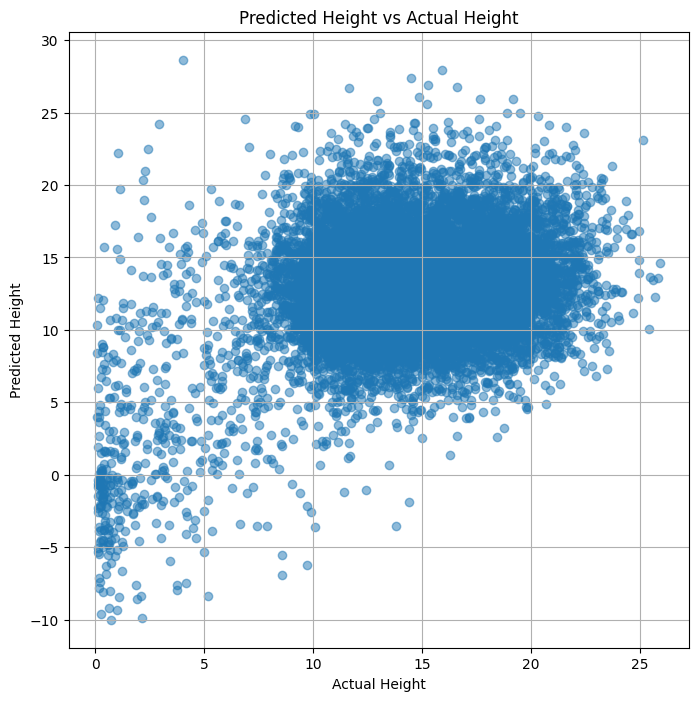

In [12]:
import torch
import matplotlib.pyplot as plt

predictions = []
actual_values = []

model.eval()

for i in range(0, 13914):
    img_array, actual_value = dataset.__getitem__(i)

    with torch.no_grad():
        output = model(img_array.unsqueeze(0))
    
    predictions.append(output.item())  
    actual_values.append(actual_value) 

plt.figure(figsize=(8, 8))  
plt.scatter(actual_values, predictions, alpha=0.5)
plt.title('Predicted Height vs Actual Height')
plt.xlabel('Actual Height')
plt.ylabel('Predicted Height')
plt.grid(True)
plt.show()


# Extracting Mean, SD, Min and Max values of Stacked Image

In [1]:
# MEAN
import rasterio
import os

# Path to the Stacked image image dataset
Stacked_image_path = "/kaggle/input/stacked-dataset/stacked_image1 (1).tif"

#output_folder = "/content/drive/MyDrive/NRSC/Parameter_values"

band_mean = []
band_std = []
band_min = []
band_max = []

with rasterio.open(Stacked_image_path) as src:
    for band_number in range(1, src.count + 1):
        band_data = src.read(band_number)

        band_mean.append(band_data.mean())
        band_std.append(band_data.std())
        band_min.append(band_data.min())
        band_max.append(band_data.max())

        # Store the mean value in a text file
        #parameter_name = f"mean_band{band_number}.txt"
        #output_file_path = os.path.join(output_folder, parameter_name)
        #with open(output_file_path, 'w') as f:
            #f.write(str(mean_value))

In [2]:
band_mean, band_std ,band_min, band_max

([205.50667857940584,
  338.1868560521453,
  202.5277695426456,
  603.5985149687629,
  2023.1472989894478,
  2556.898537982009,
  2709.065901137802,
  1336.9043948531553,
  592.1683858915264,
  63873.47875335892,
  64440.339812915845],
 [47.755313506682675,
  67.92542194155001,
  79.47636136545246,
  115.35385947673218,
  238.81464500715396,
  305.89980603340865,
  387.83081943462383,
  197.25797369243642,
  140.18532943799747,
  10284.139488617793,
  8347.656554971149],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1150, 1476, 1636, 1951, 3668, 4656, 5368, 3400, 2595, 65535, 65534])

In [3]:
band_mean=[205.50667857940584,
  338.1868560521453,
  202.5277695426456,
  603.5985149687629,
  2023.1472989894478,
  2556.898537982009,
  2709.065901137802,
  1336.9043948531553,
  592.1683858915264,
  63873.47875335892,
  64440.339812915845]
band_std=[47.755313506682675,
  67.92542194155001,
  79.47636136545246,
  115.35385947673218,
  238.81464500715396,
  305.89980603340865,
  387.83081943462383,
  197.25797369243642,
  140.18532943799747,
  10284.139488617793,
  8347.656554971149]


In [4]:
band_mean = [205.50667857940584, 338.1868560521453, 202.5277695426456, 603.5985149687629, 2023.1472989894478, 2556.898537982009, 2709.065901137802,
             1336.9043948531553, 592.1683858915264, 63873.47875335892, 64440.339812915845]
band_std = [47.755313506682675, 67.92542194155001, 79.47636136545246, 115.35385947673218, 238.81464500715396, 305.89980603340865, 387.83081943462383,
            197.25797369243642, 140.18532943799747, 10284.139488617793, 8347.656554971149]
band_min = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
band_max = [1150, 1476, 1636, 1951, 3668, 4656, 5368, 3400, 2595, 65535, 65534]

normalized_band_mean = [(mean - min_val) / (max_val - min_val) for mean, min_val, max_val in zip(band_mean, band_min, band_max)]
normalized_band_std = [(std - min_val) / (max_val - min_val) for std, min_val, max_val in zip(band_std, band_min, band_max)]

print("Normalized mean values for each band:", normalized_band_mean)
print("Normalized std values for each band:", normalized_band_std)

Normalized mean values for each band: [0.17870145963426595, 0.22912388621419058, 0.12379448016054131, 0.30937904406394817, 0.5515668754060654, 0.5491620571267202, 0.5046695046828991, 0.3932071749568104, 0.2281959097847886, 0.9746468109156774, 0.9833115606084757]
Normalized std values for each band: [0.04152635957102841, 0.04601993356473578, 0.048579682986217884, 0.059125504601092865, 0.06510759133237567, 0.06570013016181457, 0.07224866233878983, 0.05801705108601071, 0.05402132155606839, 0.15692590964549924, 0.12737901783762853]


# Stacked Image data preparation

In [5]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import numpy as np
import os
import rasterio
import pandas as pd

class GeoTIFFDataset(Dataset):
    def __init__(self, root_dir, hgt_csv, band_mean, band_std, transform=None):
        self.root_dir = root_dir
        self.band_mean = band_mean
        self.band_std = band_std
        self.csv_data = hgt_csv
        self.transform = transform
        self.file_list = os.listdir(root_dir)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError("Index %d is out of range" % idx)
        
        image_name = self.file_list[idx]
        image_id = self.file_list[idx].split('.')[0][:1].upper() + self.file_list[idx].split('.')[0][1:]
        filtered_df = self.csv_data[self.csv_data['Patch ID'] == image_id].reset_index()
        value = filtered_df.loc[0, 'DN_Values'].astype(np.float32)

        img_path = os.path.join(self.root_dir, image_name[:1].lower() + image_name[1:])
        img = rasterio.open(img_path)
        image_np = img.read().astype(np.float32)  

        if image_np.shape[0] != len(self.band_mean):
            raise ValueError(f"Image {image_name} has {image_np.shape[0]} channels but expected {len(self.band_mean)}.")

        for i in range(image_np.shape[0]):
            image_np[i, :, :] = (image_np[i, :, :] - self.band_mean[i]) / self.band_std[i]

        image_np = np.transpose(image_np, (1, 2, 0)) 

        if self.transform:
            image = self.transform(image_np)
        else:
            to_tensor = transforms.ToTensor()
            image = to_tensor(image_np)

        return image, value

band_mean = [0.17870145963426595, 0.22912388621419058, 0.12379448016054131, 0.30937904406394817, 0.5515668754060654, 0.5491620571267202, 0.5046695046828991, 0.3932071749568104, 0.2281959097847886, 0.9746468109156774, 0.9833115606084757]
band_std = [0.04152635957102841, 0.04601993356473578, 0.048579682986217884, 0.059125504601092865, 0.06510759133237567, 0.06570013016181457, 0.07224866233878983, 0.05801705108601071, 0.05402132155606839, 0.15692590964549924, 0.12737901783762853]

root_dir = '/kaggle/input/stacked-dataset/New_Stacked_patches-20240530T065527Z-001/New_Stacked_patches'

hgt_csv = pd.read_csv('/kaggle/input/project1/hgt_pixels.csv')
hgt_csv_valid = hgt_csv[hgt_csv.DN_Values > 0]

dataset1 = GeoTIFFDataset(root_dir, hgt_csv_valid, band_mean, band_std)

val_split = 0.2
seed = 42
torch.manual_seed(seed)
batch_size = 4096

train_set, val_set = random_split(dataset1, [int(len(dataset1) * (1 - val_split)), len(dataset1) - int(len(dataset1) * (1 - val_split))])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)



# Model Setting for Stacked Image

In [6]:
import torch
from torch import nn

class HeightCNN(nn.Module):
  def __init__(self):
    super(HeightCNN, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=11, out_channels=16, kernel_size=3, padding=1)
    self.relu1 = nn.ReLU(inplace=True)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
    self.relu2 = nn.ReLU(inplace=True)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.fc1 = nn.Linear(in_features=32 * 2 * 2, out_features=64)
    self.relu3 = nn.ReLU(inplace=True)
    self.fc2 = nn.Linear(in_features=64, out_features=1)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.relu2(x)
    x = self.pool2(x)
    x = torch.flatten(x, 1)  
    x = self.fc1(x)
    x = self.relu3(x)
    x = self.fc2(x)
    return x


In [7]:
def save_checkpoint(epoch, model, optimizer, filename="height_model_{epoch}.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, filename.format(epoch=epoch))

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Model Training for Stacked Image

In [ ]:
import tqdm

num_epochs =100
new_model = HeightCNN()
new_model.to(device)

optimizer = torch.optim.Adam(new_model.parameters(), lr=0.01)
criterion = nn.MSELoss()

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f"Epoch: {epoch+1}/{num_epochs}")

    train_loss = 0
    new_model.train()  
    pbar = tqdm.tqdm(total=len(train_loader))
    for images, values in train_loader:
        images = images.to(device)
        values = values.to(device)
        
        optimizer.zero_grad()

        output = new_model(images)
        values = values.view(images.shape[0], 1)
        loss = criterion(output, values)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        pbar.update(1)
        if (epoch + 1) % 5 == 0:
            save_checkpoint(epoch + 1, new_model, optimizer) 
    pbar.close()
    
    val_loss = 0
    new_model.eval()  
    with torch.no_grad():  
        for images, values in val_loader:
            images = images.to(device)
            values = values.to(device)
            
            output = new_model(images)
            values = values.view(images.shape[0], 1)
            val_loss += criterion(output, values).item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    print(f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    
new_model.eval()  
if device == "cuda":
    model = new_model.cpu()  

save_checkpoint(num_epochs, new_model.cpu(), optimizer)



In [25]:
band_mean =[205.50667857940584,338.1868560521453,202.5277695426456,603.5985149687629,2023.1472989894478,2556.898537982009,
  2709.065901137802,1336.9043948531553,592.1683858915264,63873.47875335892,64440.339812915845],
band_std = [47.755313506682675,67.92542194155001,79.47636136545246,115.35385947673218,238.81464500715396,305.89980603340865,
  387.83081943462383,197.25797369243642,140.18532943799747,10284.139488617793,8347.656554971149]

# Predict for a new image chip
def read_image(image_path):
    image_open = rasterio.open(image_path)
    image_np = image_open.read()
    image_np = np.transpose(image_np, (1, 2, 0))

    # Normalize each band
    normalized_img = np.zeros_like(image_np, dtype=np.float32)

    for i in range(image_np.shape[2]):
        normalized_img[:, :, i] = (image_np[:, :, i] - band_mean[i]) / band_std[i]
        
    to_tensor = transforms.ToTensor()
    image = to_tensor(normalized_img)
    
    return image

In [ ]:
new_model.eval()

for i in range(0,13914):
    img_array, actual_value = dataset1.__getitem__(i)

    with torch.no_grad():  
        output = new_model(img_array.unsqueeze(0))
    print(f'Predicted height: {output}, Actual height: {actual_value}')

# Predicting Raster Image for Stacked Chips

In [27]:
import numpy as np
import rasterio
from rasterio.transform import from_origin

reference_image_path = '/kaggle/input/project1/chm_raster100 (2).tif'
with rasterio.open(reference_image_path) as src:
    reference_profile = src.profile
    reference_data = src.read(1)

height, width = reference_data.shape
transform = reference_profile['transform']

predicted_data = np.zeros((height, width), dtype=np.float32)

new_model.eval()

for index in range(len(dataset1)):
    img_array, actual_value = dataset1.__getitem__(index)
    with torch.no_grad():
        output = new_model(img_array.unsqueeze(0))
    predicted_value = abs(output.item())
    
    image_name = dataset1.file_list[index]
    image_id = image_name.split('.')[0]  
    parts = image_id.split('_')
    row, col = int(parts[1]), int(parts[2])

    if predicted_value >= 0:
        predicted_data[row, col] = predicted_value
    else:
        predicted_data[row, col] = 0

predicted_profile = reference_profile.copy()
predicted_profile['dtype'] = 'float32'

predicted_image_path = '/kaggle/working/Stacked_predicted_image.tif'
with rasterio.open(predicted_image_path, 'w', **predicted_profile) as dst:
    dst.write(predicted_data, 1)

print(f"New raster image created: {predicted_image_path}")


New raster image created: /kaggle/working/Stacked_predicted_image.tif


# #----------------------------------------------------------#
# # Junk
# #----------------------------------------------------------#

In [ ]:
import os
import numpy as np
from osgeo import gdal
from tqdm import tqdm

# Function to normalize a band using mean and standard deviation
def normalize_band(band, band_mean, band_std):
    return (band - band_mean) / band_std

# Function to read mean and standard deviation values from text files
def read_mean_std_values(mean_dir, std_dir, chip_name, band_count):
    mean_values = []
    std_values = []
    for band_num in range(1, band_count+1):
        with open(os.path.join(mean_dir, f"mean_band{band_num}.txt"), "r") as mean_file:
            mean_value = float(mean_file.readline().strip())
            mean_values.append(mean_value)
        with open(os.path.join(std_dir, f"std_dev_band{band_num}.txt"), "r") as std_file:
            std_value = float(std_file.readline().strip())
            std_values.append(std_value)
    return mean_values, std_values

# Function to normalize chips based on mean and standard deviation values
def normalize_chips(chips_dir, mean_dir, std_dir, output_dir):
    # List all chip files
    chip_files = os.listdir(chips_dir)

    processed_files = []  # To keep track of processed files

    # Check for already processed files
    processed_files = [file for file in os.listdir(output_dir)]

    remaining_files = [file for file in chip_files if file not in processed_files]

    for chip_file in tqdm(remaining_files, desc="Normalizing chips"):
        # Load chip
        chip_path = os.path.join(chips_dir, chip_file)
        dataset = gdal.Open(chip_path)

        # Get the number of bands
        band_count = dataset.RasterCount

        # Read mean and standard deviation values for each band
        mean_values, std_values = read_mean_std_values(mean_dir, std_dir, chip_file, band_count)

        # Initialize list to store normalized bands
        normalized_bands = []

        # Normalize each band
        for i in range(band_count):
            band = dataset.GetRasterBand(i + 1).ReadAsArray().astype(np.float32)
            normalized_band = normalize_band(band, mean_values[i], std_values[i])
            normalized_bands.append(normalized_band)

        # Save normalized chip
        output_path = os.path.join(output_dir, chip_file)
        driver = gdal.GetDriverByName('GTiff')
        output_dataset = driver.Create(output_path, dataset.RasterXSize, dataset.RasterYSize, band_count, gdal.GDT_Float32)

        for i, band_data in enumerate(normalized_bands):
            output_band = output_dataset.GetRasterBand(i + 1)
            output_band.WriteArray(band_data)

        output_dataset.SetGeoTransform(dataset.GetGeoTransform())
        output_dataset.SetProjection(dataset.GetProjection())

        output_dataset.FlushCache()
        output_dataset = None

    print("Normalization completed.")

# Paths to directories
chips_dir = "/content/drive/MyDrive/NRSC/New_Clipped_images"
mean_dir = "/content/drive/MyDrive/NRSC/Parameter_values/Mean"
std_dir = "/content/drive/MyDrive/NRSC/Parameter_values/SD"
output_dir = "/content/drive/MyDrive/NRSC/Normalized_chips"

# Normalize chips using mean and standard deviation
normalize_chips(chips_dir, mean_dir, std_dir, output_dir)


In [ ]:
# REMOVING CHIPS WHOSE DN VALUES LESS THAND 5
import os
import shutil

Normalized_chips = "/content/drive/MyDrive/NRSC/Normalized_chips"
new_folder = "/content/drive/MyDrive/NRSC/New_Normalized_chips"

filtered_df['Patch ID'] = filtered_df['Patch ID'].str.lower()

for image_filename in os.listdir(Normalized_chips):
    if image_filename.endswith(".tif"):
        patch_id_from_filename = os.path.splitext(image_filename)[0].lower()
        if patch_id_from_filename in filtered_df['Patch ID'].values:
            image_file_path = os.path.join(Normalized_chips, image_filename)

            try:
                shutil.copy(image_file_path, new_folder)
                print(f"Image {image_filename} copied successfully.")
            except Exception as e:
                print(f"Error occurred while copying image {image_filename}: {e}")
        else:
            print(f"Patch ID '{patch_id_from_filename}' not found in the DataFrame.")


<ipython-input-6-d9eba134fb94>:8: SettingWithCopyWarning: 

A value is trying to be set on a copy of a slice from a DataFrame.

Try using .loc[row_indexer,col_indexer] = value instead



See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  filtered_df['Patch ID'] = filtered_df['Patch ID'].str.lower()


Streaming output truncated to the last 5000 lines.

Image patch_88_63.tif copied successfully.

Image patch_88_64.tif copied successfully.

Image patch_88_65.tif copied successfully.

Image patch_88_66.tif copied successfully.

Image patch_88_67.tif copied successfully.

Image patch_88_68.tif copied successfully.

Image patch_88_69.tif copied successfully.

Image patch_88_70.tif copied successfully.

Image patch_88_71.tif copied successfully.

Image patch_88_72.tif copied successfully.

Image patch_88_73.tif copied successfully.

Image patch_88_74.tif copied successfully.

Image patch_88_75.tif copied successfully.

Image patch_88_76.tif copied successfully.

Image patch_88_77.tif copied successfully.

Image patch_88_78.tif copied successfully.

Image patch_88_79.tif copied successfully.

Image patch_88_80.tif copied successfully.

Image patch_88_81.tif copied successfully.

Image patch_88_82.tif copied successfully.

Image patch_88_83.tif copied successfully.

Image patch_88_84.tif co

In [3]:
import pandas as pd

# Read the CSV file into a DataFrame
file_path = '/kaggle/input/project1/hgt_pixels.csv'
df = pd.read_csv(file_path)

# Filter out rows with DN values > 5 and Patch_51_15 is not equal to 'Patch_51_15'
filtered_df = df[(df['DN_Values'] > 5)]

# Display the resulting DataFrame
print(filtered_df)



            Patch ID  DN_Values
0          Patch_0_0   7.390527
1          Patch_0_1   5.135960
2          Patch_0_2   8.562776
3          Patch_0_3   8.505224
4          Patch_0_4   6.767704
...              ...        ...
14513  Patch_119_114   9.601645
14514  Patch_119_115  12.352250
14515  Patch_119_116   9.405808
14516  Patch_119_117  12.161224
14517  Patch_119_118  16.708530

[13529 rows x 2 columns]


In [ ]:
!pip install tensorflow

In [ ]:
!pip install keras

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras import regularizers
from tensorflow.keras.initializers import RandomNormal

# Create separate instances of RandomNormal initializer
initializer_conv2d = RandomNormal(mean=0.0, stddev=0.01)
initializer_dense = RandomNormal(mean=0.0, stddev=0.01)

model = Sequential([
    Conv2D(100, (5, 5), input_shape=(10, 10, 9),
           kernel_initializer=initializer_conv2d, kernel_regularizer=regularizers.l2(0.1)),
    LeakyReLU(),
    Flatten(),
    Dense(32, kernel_initializer=initializer_dense, kernel_regularizer=regularizers.l2(0.1)),
    LeakyReLU(),
    Dropout(0.5),
    Dense(1)  # Single output for regression
])

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()


In [7]:
!pip install tifffile

In [8]:
# SPLITTING DATA INTO TRAINING AND TESTING
import pandas as pd
import numpy as np
import os
import tifffile
import cv2
from sklearn.model_selection import train_test_split,KFold

def load_image_patches(directory):
    patches = []
    count = 0
    for filename in os.listdir(directory):
        count += 1
        if filename.lower().endswith('.tif'):
            try:
                img = tifffile.imread(os.path.join(directory, filename))
                if img is not None and not img.size == 0:
                    img_resized = cv2.resize(img, (10, 10))
                    patches.append(img_resized)
                else:
                    print(f"Error loading image: {filename}")
            except Exception as e:
                print(f"Error loading image: {filename}. Exception: {e}")
        if (count%100 ==0):
          print(f'Filenumber : {count}, Filename : {filename}')
    patches = np.array(patches)
    return patches

patches_directory = '/content/drive/MyDrive/NRSC/New_Normalized_chips'
X_patches = load_image_patches(patches_directory)

dn_values = filtered_df['DN_Values'].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X_patches, dn_values, test_size=0.2, random_state=42)


Filenumber : 100, Filename : patch_55_8.tif

Filenumber : 200, Filename : patch_55_108.tif

Filenumber : 300, Filename : patch_56_90.tif

Filenumber : 400, Filename : patch_57_71.tif

Filenumber : 500, Filename : patch_58_52.tif

Filenumber : 600, Filename : patch_59_33.tif

Filenumber : 700, Filename : patch_60_14.tif

Filenumber : 800, Filename : patch_60_114.tif

Filenumber : 900, Filename : patch_61_95.tif

Filenumber : 1000, Filename : patch_42_98.tif

Filenumber : 1100, Filename : patch_62_78.tif

Filenumber : 1200, Filename : patch_47_22.tif

Filenumber : 1300, Filename : patch_48_2.tif

Filenumber : 1400, Filename : patch_48_102.tif

Filenumber : 1500, Filename : patch_49_82.tif

Filenumber : 1600, Filename : patch_50_62.tif

Filenumber : 1700, Filename : patch_51_42.tif

Filenumber : 1800, Filename : patch_52_22.tif

Filenumber : 1900, Filename : patch_53_3.tif

Filenumber : 2000, Filename : patch_53_103.tif

Filenumber : 2100, Filename : patch_105_105.tif

Filenumber : 2200, 

In [18]:
# MODEL TRAINGING
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

checkpoint_filepath = '/content/drive/MyDrive/NRSC/Model2.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

optimizer = Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, callbacks=[model_checkpoint_callback])

loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

best_model = tf.keras.models.load_model(checkpoint_filepath)


Epoch 1/100

136/136 [==============================] - 2s 6ms/step - loss: 171.4891 - val_loss: 140.6755

Epoch 2/100

 32/136 [======>.......................] - ETA: 0s - loss: 129.7400

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

  saving_api.save_model(


136/136 [==============================] - 1s 4ms/step - loss: 106.3374 - val_loss: 78.4365

Epoch 3/100

136/136 [==============================] - 1s 4ms/step - loss: 69.7286 - val_loss: 57.2853

Epoch 4/100

136/136 [==============================] - 1s 4ms/step - loss: 61.1816 - val_loss: 51.5389

Epoch 5/100

136/136 [==============================] - 1s 4ms/step - loss: 58.2492 - val_loss: 48.3839

Epoch 6/100

136/136 [==============================] - 1s 4ms/step - loss: 54.1625 - val_loss: 45.2726

Epoch 7/100

136/136 [==============================] - 1s 4ms/step - loss: 52.4215 - val_loss: 42.9615

Epoch 8/100

136/136 [==============================] - 1s 4ms/step - loss: 49.6237 - val_loss: 40.9247

Epoch 9/100

136/136 [==============================] - 1s 4ms/step - loss: 47.8300 - val_loss: 38.9212

Epoch 10/100

136/136 [==============================] - 1s 5ms/step - loss: 45.0815 - val_loss: 37.0344

Epoch 11/100

136/136 [==============================] - 1s 4ms/st

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/NRSC/Model2.h5')

patch_input = np.expand_dims(X_test[500], axis=0)

predicted_height = model.predict(patch_input)
print(f"Original height is: {y_test[500]} and predicted height is: {predicted_height[0][0]}")

In [ ]:
model.layers

In [19]:
# PREDICTING CANOPY HEIGHT AND CONSTRUCTING RASTER IMAGE USING CHM_RASTER IMAGE AS REFERENDCE
import cv2
import numpy as np
import pandas as pd
import tifffile
import rasterio
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/NRSC/Model2.h5')

with rasterio.open('/content/drive/MyDrive/NRSC/chm_raster100.tif') as ref_raster:
    ref_meta = ref_raster.meta

grid_height, grid_width = ref_meta['height'], ref_meta['width']

raster_grid = np.zeros((grid_height, grid_width), dtype=np.float32)

for i in range(grid_height):
    for j in range(grid_width):
        filename = f'patch_{i}_{j}'
        patch_path = f'/content/drive/MyDrive/NRSC/New_Normalized_chips/{filename}.tif'
        try:
            patch = tifffile.imread(patch_path)

            patch_resized = cv2.resize(patch, (10, 10))

            patch_input = np.expand_dims(patch_resized, axis=0)

            predicted_height = model.predict(patch_input)
            print(f"filename is: {patch_path} and predicted height is: {predicted_height[0][0]}")
            raster_grid[i, j] = predicted_height[0][0]

        except FileNotFoundError:
            print(f"File {filename} not found. Skipping...")
            continue

ref_meta['dtype'] = 'float32'
with rasterio.open('/content/drive/MyDrive/NRSC/Predicted2.tif', 'w', **ref_meta) as dst_raster:
    dst_raster.write(raster_grid, 1)

print("New raster image of predicted heights has been saved.")


Streaming output truncated to the last 5000 lines.

1/1 [==============================] - 0s 50ms/step

filename is: /content/drive/MyDrive/NRSC/New_Normalized_chips/patch_97_115.tif and predicted height is: 14.539883613586426

1/1 [==============================] - 0s 37ms/step

filename is: /content/drive/MyDrive/NRSC/New_Normalized_chips/patch_97_116.tif and predicted height is: 14.087597846984863

1/1 [==============================] - 0s 33ms/step

filename is: /content/drive/MyDrive/NRSC/New_Normalized_chips/patch_97_117.tif and predicted height is: 15.016234397888184

1/1 [==============================] - 0s 38ms/step

filename is: /content/drive/MyDrive/NRSC/New_Normalized_chips/patch_97_118.tif and predicted height is: 15.261181831359863

1/1 [==============================] - 0s 31ms/step

filename is: /content/drive/MyDrive/NRSC/New_Normalized_chips/patch_97_119.tif and predicted height is: 15.701197624206543

File patch_97_120 not found. Skipping...

1/1 [================

In [ ]:
# STACKING SENTINEL-2 FOLLOWED BY SENTINEL-1 TO FORM A STACKED IMAGE
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Define paths to the Sentinel-2 and Sentinel-1 images
sentinel2_path = "/content/drive/MyDrive/NRSC/new_sentinel_2022.tif"
sentinel1_path = "/content/drive/MyDrive/NRSC/Sentinel_1_2022/sentinel_1_2022.tif"
output_path = "/content/drive/MyDrive/NRSC/Sentinel_1_2022/stacked_image1.tif"
temp_sentinel1_reprojected = "/content/drive/MyDrive/NRSC/Sentinel_1_2022/sentinel_1_2022_reprojected.tif"

with rasterio.open(sentinel2_path) as src2:
    sentinel2_bands = [src2.read(band) for band in range(1, src2.count + 1)]
    sentinel2_profile = src2.profile
    sentinel2_dtype = src2.dtypes[0]

with rasterio.open(sentinel1_path) as src1:
    transform, width, height = calculate_default_transform(
        src1.crs, sentinel2_profile['crs'], src1.width, src1.height, *src1.bounds)
    sentinel1_profile = src1.profile.copy()
    sentinel1_profile.update({
        'crs': sentinel2_profile['crs'],
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(temp_sentinel1_reprojected, 'w', **sentinel1_profile) as dst:
        for i in range(1, src1.count + 1):
            reproject(
                source=rasterio.band(src1, i),
                destination=rasterio.band(dst, i),
                src_transform=src1.transform,
                src_crs=src1.crs,
                dst_transform=transform,
                dst_crs=sentinel2_profile['crs'],
                resampling=Resampling.nearest)

with rasterio.open(temp_sentinel1_reprojected) as src1_reprojected:
    sentinel1_bands = [src1_reprojected.read(band) for band in range(1, src1_reprojected.count + 1)]
    sentinel1_dtype = src1_reprojected.dtypes[0]

if sentinel1_dtype != sentinel2_dtype:
    sentinel1_bands = [band.astype(sentinel2_dtype) for band in sentinel1_bands]

stacked_profile = sentinel2_profile.copy()
stacked_profile.update(count=len(sentinel2_bands) + len(sentinel1_bands))
stacked_bands = sentinel2_bands + sentinel1_bands

with rasterio.open(output_path, 'w', **stacked_profile) as dst:
    for idx, band in enumerate(stacked_bands, start=1):
        dst.write(band, idx)

print("Stacking completed. Stacked image saved at:", output_path)


Original Sentinel-2 Band Statistics:

Sentinel-2 - Band 1: min = 0, max = 1150, mean = 205.50667857940584

Sentinel-2 - Band 2: min = 0, max = 1476, mean = 338.1868560521453

Sentinel-2 - Band 3: min = 0, max = 1636, mean = 202.5277695426456

Sentinel-2 - Band 4: min = 0, max = 1951, mean = 603.5985149687629

Sentinel-2 - Band 5: min = 0, max = 3668, mean = 2023.1472989894478

Sentinel-2 - Band 6: min = 0, max = 4656, mean = 2556.898537982009

Sentinel-2 - Band 7: min = 0, max = 5368, mean = 2709.065901137802

Sentinel-2 - Band 8: min = 0, max = 3400, mean = 1336.9043948531553

Sentinel-2 - Band 9: min = 0, max = 2595, mean = 592.1683858915264



Original Sentinel-1 Band Statistics:

Sentinel-1 - Band 1: min = nan, max = nan, mean = nan

Sentinel-1 - Band 2: min = nan, max = nan, mean = nan



Stacked Image Band Statistics:

Stacked Image - Band 1: min = 0, max = 1150, mean = 205.50667857940584

Stacked Image - Band 2: min = 0, max = 1476, mean = 338.1868560521453

Stacked Image - Band

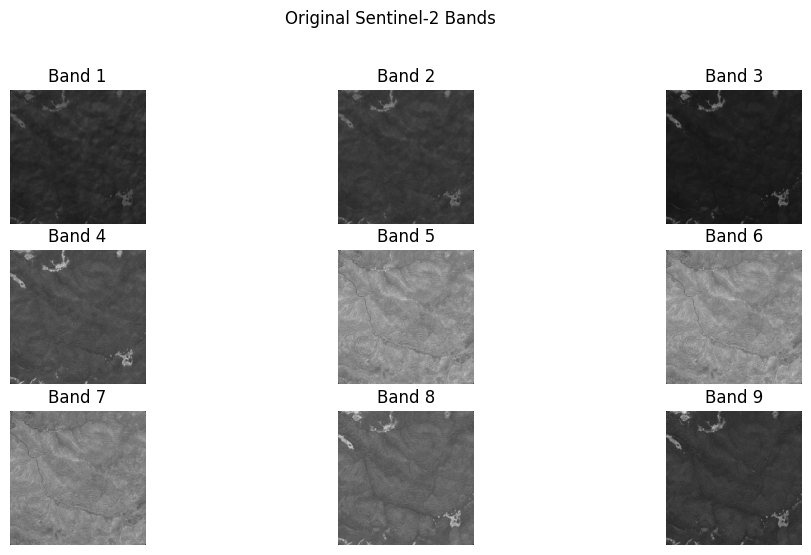

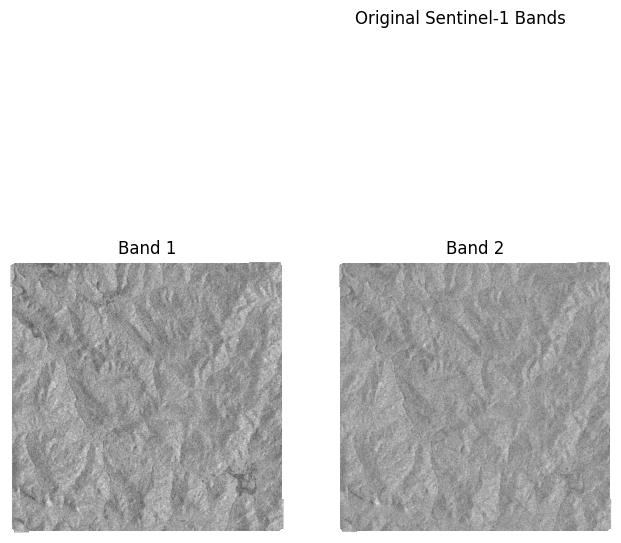

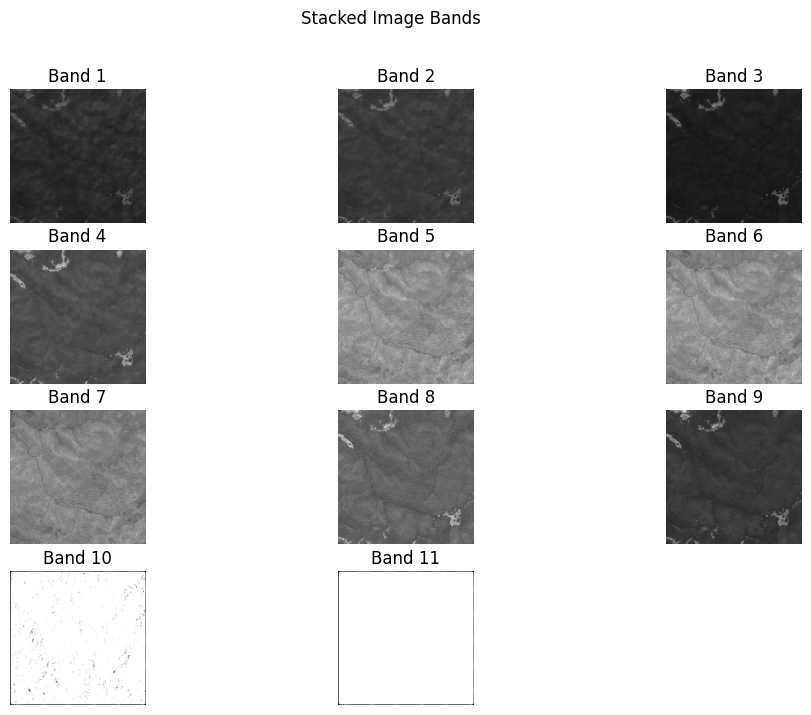

Sentinel-2 Projection: EPSG:32645

Sentinel-1 Projection: EPSG:32645

Stacked Image Projection: EPSG:32645

Sentinel-2 Geotransform: | 10.00, 0.00, 423650.00|

| 0.00,-10.00, 2412950.00|

| 0.00, 0.00, 1.00|

Sentinel-1 Geotransform: | 9.60, 0.00, 423591.14|

| 0.00,-9.60, 2413005.83|

| 0.00, 0.00, 1.00|

Stacked Image Geotransform: | 10.00, 0.00, 423650.00|

| 0.00,-10.00, 2412950.00|

| 0.00, 0.00, 1.00|


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio

# Define paths
output_path = "/content/drive/MyDrive/NRSC/Sentinel_1_2022/stacked_image1.tif"
sentinel2_path = "/content/drive/MyDrive/NRSC/new_sentinel_2022.tif"
sentinel1_path = "/content/drive/MyDrive/NRSC/Sentinel_1_2022/sentinel_1_2022_reprojected.tif"

# Open the original Sentinel-2 image
with rasterio.open(sentinel2_path) as src2:
    sentinel2_bands = [src2.read(band) for band in range(1, src2.count + 1)]
    sentinel2_profile = src2.profile

# Open the original Sentinel-1 image
with rasterio.open(sentinel1_path) as src1:
    sentinel1_bands = [src1.read(band) for band in range(1, src1.count + 1)]
    sentinel1_profile = src1.profile

# Open the stacked image
with rasterio.open(output_path) as stacked_src:
    stacked_bands = [stacked_src.read(band) for band in range(1, stacked_src.count + 1)]
    stacked_profile = stacked_src.profile

# Ensure the number of bands is correct
assert len(stacked_bands) == len(sentinel2_bands) + len(sentinel1_bands), "The number of bands in the stacked image is incorrect."

# Function to compare band statistics
def print_statistics(bands, name):
    for i, band in enumerate(bands, start=1):
        print(f"{name} - Band {i}: min = {np.min(band)}, max = {np.max(band)}, mean = {np.mean(band)}")

# Compare statistics of original and stacked bands
print("Original Sentinel-2 Band Statistics:")
print_statistics(sentinel2_bands, "Sentinel-2")

print("\nOriginal Sentinel-1 Band Statistics:")
print_statistics(sentinel1_bands, "Sentinel-1")

print("\nStacked Image Band Statistics:")
print_statistics(stacked_bands, "Stacked Image")

# Visualize bands to ensure they look correct
def visualize_bands(bands, title):
    plt.figure(figsize=(12, 8))
    for i, band in enumerate(bands, start=1):
        plt.subplot((len(bands) // 3) + 1, 3, i)
        plt.imshow(band, cmap='gray')
        plt.title(f'Band {i}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Visual inspection of the bands
visualize_bands(sentinel2_bands, "Original Sentinel-2 Bands")
visualize_bands(sentinel1_bands, "Original Sentinel-1 Bands")
visualize_bands(stacked_bands, "Stacked Image Bands")

# Check projections and geotransforms
print(f"Sentinel-2 Projection: {sentinel2_profile['crs']}")
print(f"Sentinel-1 Projection: {sentinel1_profile['crs']}")
print(f"Stacked Image Projection: {stacked_profile['crs']}")

print(f"Sentinel-2 Geotransform: {sentinel2_profile['transform']}")
print(f"Sentinel-1 Geotransform: {sentinel1_profile['transform']}")
print(f"Stacked Image Geotransform: {stacked_profile['transform']}")


In [ ]:
# CLIPPING THE STACKED IMAGE INTO CHIPS USING SHAPEFILES OF RASTERIMAGE
import rasterio
import geopandas as gpd
from rasterio.mask import mask
from rasterio.windows import from_bounds
import math

stacked_image_path = "/content/drive/MyDrive/NRSC/Sentinel_1_2022/stacked_image1.tif"

rows = 120
cols = 121

start_row = 63

for i in range(start_row, rows):
    for j in range(cols):
        shapefile_path = f"/content/drive/MyDrive/NRSC/Shapefiles/shapefile_{i}_{j}.shp"

        clipped_output_path = f"/content/drive/MyDrive/NRSC/Sentinel_1_2022/Stacked_patches/patch_{i}_{j}.tif"

        shapefile = gpd.read_file(shapefile_path)

        with rasterio.open(stacked_image_path) as src:
            raster_crs = src.crs
            if shapefile.crs is None:
                # If the shapefile does not have a CRS, assign it the CRS of the raster
                shapefile.set_crs(raster_crs, inplace=True)
            else:
                # If the shapefile has a CRS, reproject it to match the raster's CRS
                shapefile = shapefile.to_crs(raster_crs)

            shapefile_bounds = shapefile.total_bounds

            bbox_width = shapefile_bounds[2] - shapefile_bounds[0]
            bbox_height = shapefile_bounds[3] - shapefile_bounds[1]

            window_width = min(512, math.ceil(bbox_width * src.transform.a))
            window_height = min(512, math.ceil(bbox_height * src.transform.e))

            window = from_bounds(*shapefile_bounds, transform=src.transform, width=window_width, height=window_height)

            clipped_data, clipped_transform = src.read(window=window), src.window_transform(window)

            if clipped_data.any():
                clipped_meta = {
                    "driver": "GTiff",
                    "height": clipped_data.shape[1],
                    "width": clipped_data.shape[2],
                    "count": clipped_data.shape[0],
                    "dtype": clipped_data.dtype,
                    "crs": src.crs,
                    "transform": clipped_transform
                }

                with rasterio.open(clipped_output_path, "w", **clipped_meta) as dest:
                    dest.write(clipped_data)

                print("Clipping completed successfully. Clipped image saved at:", clipped_output_path)
            else:
                print("Error: Clipped data has invalid dimensions. Check the bounding box coordinates.")


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# REMOVING CHIPS WHOSE DN VALUES LESS THAND 5
import os
import shutil

Normalized_chips = "/content/drive/MyDrive/NRSC/Sentinel_1_2022/Stacked_patches"
new_folder = "/content/drive/MyDrive/NRSC/Sentinel_1_2022/New_Stacked_patches"

filtered_df['Patch ID'] = filtered_df['Patch ID'].str.lower()

for image_filename in os.listdir(Normalized_chips):
    if image_filename.endswith(".tif"):
        patch_id_from_filename = os.path.splitext(image_filename)[0].lower()
        if patch_id_from_filename in filtered_df['Patch ID'].values:
            image_file_path = os.path.join(Normalized_chips, image_filename)

            try:
                shutil.copy(image_file_path, new_folder)
                print(f"Image {image_filename} copied successfully.")
            except Exception as e:
                print(f"Error occurred while copying image {image_filename}: {e}")
        else:
            print(f"Patch ID '{patch_id_from_filename}' not found in the DataFrame.")
